In [1]:
import sklearn.datasets as skds
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from similarity import *
import scipy.sparse as scpsp
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans

# Importing and Prepping Dataset

In [2]:
twenty_news_complete = skds.fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))
categories = list(twenty_news_complete.target_names)

vectorizer = TfidfVectorizer()
model = vectorizer.fit(twenty_news_complete.data)

twenty_news_cats = list()
for category in categories:
    cat_data = skds.fetch_20newsgroups(categories=[category],remove=('headers', 'footers', 'quotes'))
    cat_matrix = vectorizer.transform(cat_data.data)
    cat_vecs = np.transpose(cat_matrix[np.random.randint(cat_matrix.shape[0],size=100),:])
    cat_vecs_dense = np.asarray(scpsp.csr_matrix.todense(cat_vecs))
    twenty_news_cats.append(cat_vecs_dense)

# Average Distance Calculation (without normalization)

In [4]:
warnings.filterwarnings('ignore')

numtrials = 50

rank = 10
dist_matrix = np.zeros([20,20])

with tqdm(total=numtrials * 10 * 21) as pbar:
    for trial in tqdm(range(numtrials),display=False):
        twenty_news_cats = list()
        for category in categories:
            cat_data = skds.fetch_20newsgroups(categories=[category],remove=('headers', 'footers', 'quotes'))
            cat_matrix = vectorizer.transform(cat_data.data)
            cat_vecs = np.transpose(cat_matrix[np.random.randint(cat_matrix.shape[0],size=100),:])
            cat_vecs_dense = np.asarray(scpsp.csr_matrix.todense(cat_vecs))
            twenty_news_cats.append(cat_vecs_dense)
        
        for i in tqdm(range(20),display=False):
            for j in tqdm(range(i,20),display=False):
                dist_value = sim(twenty_news_cats[i],twenty_news_cats[j],rank)
                dist_matrix[i,j] += dist_value
                if i != j:
                    dist_matrix[j,i] += dist_value
                pbar.update(1)
            
dist_matrix = dist_matrix/numtrials

  0%|          | 0/10500 [00:00<?, ?it/s]

In [5]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(dist_matrix)
order = np.argsort(kmeans.labels_)

row_sort_matrix = dist_matrix[order,:]
sort_matrix = row_sort_matrix[:,order]

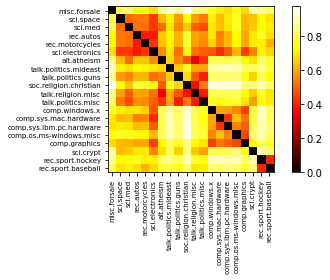

In [6]:
fig, ax = plt.subplots(1,1)
img = ax.imshow(sort_matrix, cmap='hot', interpolation='nearest')
label_list = [categories[i] for i in order]
ax.set_xticks(np.linspace(0, 19, num=20))
ax.set_yticks(np.linspace(0, 19, num=20))
ax.set_xticklabels(label_list,FontSize=7)
ax.set_yticklabels(label_list,FontSize=7)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
fig.colorbar(img)
fig.tight_layout()
fig.show()
fig.savefig('avg_20news_distance.eps', format='eps')

In [7]:
[kmeans.labels_[i] for i in order]

[0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 5, 5]